# Data Modeling with ANN

In [1]:
import keras
import tensorflow as tf

### 1. Data Prep

In [3]:
import numpy as np
import pandas as pd
from joblib import dump, load # this lib. used to save and load the model.
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.layers import Input, Dense, Dropout, BatchNormalization

random.seed(46)
np.random.seed(46)
tf.random.set_seed(46)

# Environment settings and data loading
data_path = '../diabetes.csv'

In [6]:
# Normalizing Inputs and Save the Scaler
def preprocess_data(filepath):
    data = pd.read_csv(filepath)
    scaler = StandardScaler()
    X = scaler.fit_transform(data.drop('Outcome', axis=1))
    y = data['Outcome'].values
    dump(scaler, 'scaler.joblib')
    return X, y

X, y = preprocess_data(data_path)
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [7]:
# Train Validaiton and Tensorflow DataSet
def prepare_datasets(X_train, X_val, y_train, y_val, batch_size=None):

    if batch_size is None:
        batch_size = len(X_train)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    train_dataset = train_dataset.shuffle(buffer_size=len(X_train)).batch(batch_size)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_val, y_val))

    val_dataset = val_dataset.batch(batch_size)

    return train_dataset, val_dataset

train_ds, val_ds = prepare_datasets(X_train, X_val, y_train, y_val)

In [8]:
train_ds

<_BatchDataset element_spec=(TensorSpec(shape=(None, 8), dtype=tf.float64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

### 2. Modelling

In [9]:
# BUILD THE MODEL
model = Sequential([
    Input(shape=(train_ds.element_spec[0].shape[1],)), # Adding dimension information via tfds (Input Layer ~ Independent variables number)

    Dense(50, activation='relu', kernel_regularizer=l2(0.001)),
    # 1st hidden layer: 50 neuron, ReLu Func, L2 regularization(lambda=0.001)

    BatchNormalization(), # 2nd hidden layer; this was standardizing activations, Remember!
    Dropout(0.5), # 3rd hidden layer; Neuron elimination  => randomly %50 of neurons shall be eliminated!
    # The correct value can be found by trial and doing wrong process! 
    
    Dense(1, activation='sigmoid') # output layer
])

optimizer = SGD(learning_rate=0.01, momentum=0.0) # SGD(Stochastic Gradient Descent)
# momentum => the argument used to make calculations by taking into account gradient information from the past

model.compile(optimizer=optimizer,
              loss="binary_crossentropy",
              metrics=["accuracy", "AUC"])

In [11]:
# CALLBACKS
# Callbacks are functions that will be called at certain points during model training. 
# We would like to make some touches such as monitoring, controlling and intervening in the training process. 
# During the training process, callback functions are used for purposes such as making certain recordings, monitoring and pausing them.
early_stopping = EarlyStopping(
    monitor='val_loss', # early stopping shall be done according to validation loss
    patience=20, # 20 iteration margin before stopping the model training
    verbose=1, # give report
    restore_best_weights=True) # don't save these weights after stopping

# To save the model to the working environment, "ModelCheckpoint()" can be used.
model_checkpoint = ModelCheckpoint(
    'best_model.keras',
    monitor='val_loss',
    verbose=1,
    save_best_only=True)

# NOTE: When Early_Stopping stops the model, the model saved by ModelCheckpoint and the weight values that Early_Stopping restores may not be the same.
# The way to avoid this is to use the => "restore_best_weights=True" argument as True.

### 3. Model Training

In [13]:
history = model.fit(train_ds,
            # epochs=1000,
            epochs=20,
            validation_data=val_ds,
            verbose=2,
            callbacks=[early_stopping, model_checkpoint])

# model.get_config()

for layer in model.layers:
    config = layer.get_config()
    print(f"Layer type: {type(layer).__name__}")
    print("Initializer for weights:", config.get('kernel_initializer'))
# ---Output Example---    
# Layer type: Dense
# Initializer for weights: {'module': 'keras.initializers', 'class_name': 'GlorotUniform', 'config': {'seed': None}, 'registered_name': None}

Epoch 1/20

Epoch 1: val_loss improved from 0.66610 to 0.66389, saving model to best_model.keras
1/1 - 0s - 62ms/step - AUC: 0.5971 - accuracy: 0.5668 - loss: 0.8268 - val_AUC: 0.5771 - val_accuracy: 0.6818 - val_loss: 0.6639
Epoch 2/20

Epoch 2: val_loss improved from 0.66389 to 0.66114, saving model to best_model.keras
1/1 - 0s - 119ms/step - AUC: 0.6091 - accuracy: 0.5863 - loss: 0.8021 - val_AUC: 0.5886 - val_accuracy: 0.6753 - val_loss: 0.6611
Epoch 3/20

Epoch 3: val_loss improved from 0.66114 to 0.65888, saving model to best_model.keras
1/1 - 0s - 57ms/step - AUC: 0.6394 - accuracy: 0.5961 - loss: 0.7676 - val_AUC: 0.5979 - val_accuracy: 0.6818 - val_loss: 0.6589
Epoch 4/20

Epoch 4: val_loss improved from 0.65888 to 0.65661, saving model to best_model.keras
1/1 - 0s - 45ms/step - AUC: 0.6284 - accuracy: 0.5847 - loss: 0.7910 - val_AUC: 0.6086 - val_accuracy: 0.6883 - val_loss: 0.6566
Epoch 5/20

Epoch 5: val_loss improved from 0.65661 to 0.65409, saving model to best_model.kera

### 4. Evaluating Model Results

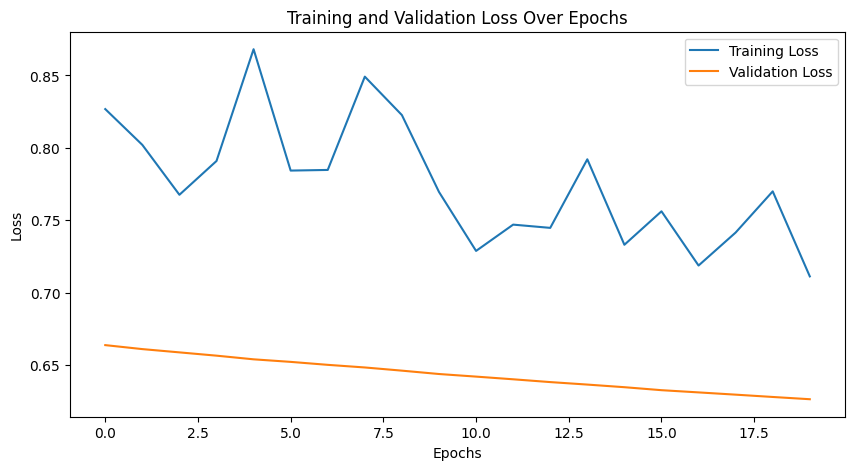

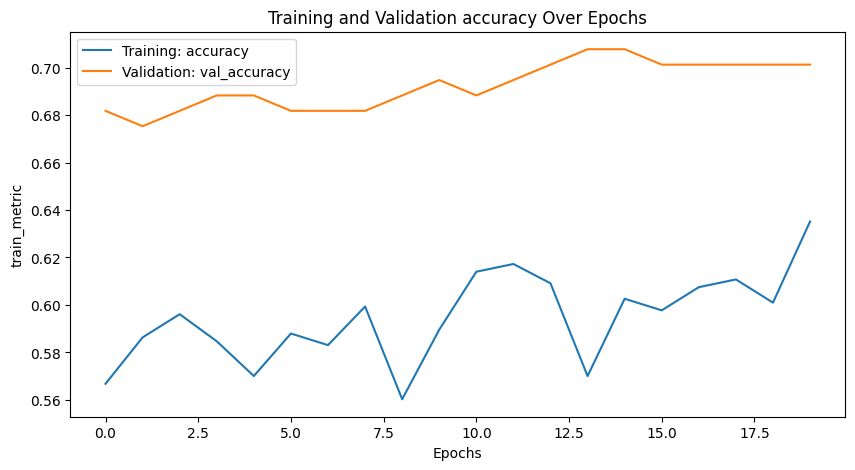

In [14]:
# Questions that may come to our mind during Model Evaluation;
# Which is the best iteration? , 
# What were the best values?, 
# What is our Train Error? , 
# What is our Validation Error? , 
# What are AUC/Accuracy values?, 
# Should we create and examine charts to avoid falling into overfitting?, 
# After saving the model to disk, will we read back what we saved? ,
# Is there information on the best iteration?

def plot_training_history(history, train_loss='loss', train_metric='accuracy', val_loss='val_loss', val_metric='val_accuracy'):

    #Loss
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_loss], label='Training Loss')
    plt.plot(history.history[val_loss], label='Validation Loss')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Metrics
    plt.figure(figsize=(10, 5))
    plt.plot(history.history[train_metric], label=f"Training: {train_metric}")
    plt.plot(history.history[val_metric], label=f"Validation: {val_metric}")
    plt.title(f'Training and Validation {train_metric} Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel(f'train_metric')
    plt.legend()
    plt.show()

plot_training_history(history)

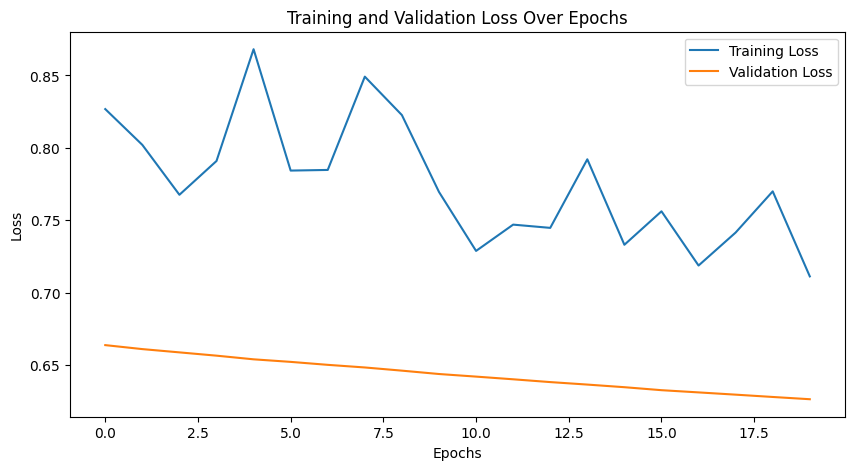

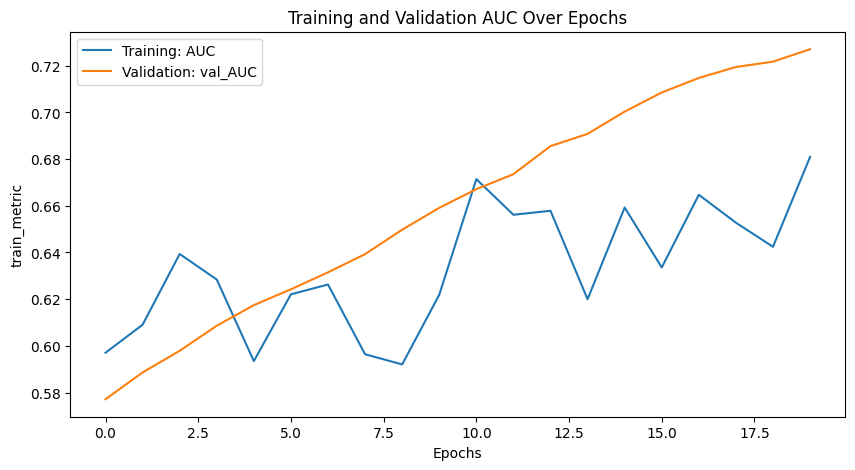

In [16]:
plot_training_history(history, train_metric="AUC", val_metric="val_AUC") 

In [17]:
def get_best_epoch_details(history): # this func. was written to retrieve the recorded epoch values according to the smallest loss value.

    val_losses = history.history['val_loss']

    min_val_loss_index = val_losses.index(min(val_losses))

    best_epoch = min_val_loss_index + 1

    epoch_details = {}
    for key in history.history.keys():
        epoch_details[key] = history.history[key][min_val_loss_index]

    epoch_details['best_epoch'] = best_epoch
    return epoch_details

best_epoch_details = get_best_epoch_details(history)
print(f"Best epoch details: {best_epoch_details}")

Best epoch details: {'AUC': 0.6809384822845459, 'accuracy': 0.6351791620254517, 'loss': 0.711320698261261, 'val_AUC': 0.7270890474319458, 'val_accuracy': 0.701298713684082, 'val_loss': 0.6265520453453064, 'best_epoch': 20}


In [22]:
# LOADING BEST MODEL
best_model = load_model('best_model.keras') # It could be preferred as joblib while loading the model
best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 50)                  │             450 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 50)                  │             200 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 703 (2.75 KB)

 Trainable params: 601 (2.35 KB)

 Non-trainable params: 100 (400.00 B)

 Optimizer params: 2 (12.00 B)

In [19]:
best_model.get_config()

{'name': 'sequential',
 'trainable': True,
 'dtype': {'module': 'keras',
  'class_name': 'DTypePolicy',
  'config': {'name': 'float32'},
  'registered_name': None},
 'layers': [{'module': 'keras.layers',
   'class_name': 'InputLayer',
   'config': {'batch_shape': (None, 8),
    'dtype': 'float32',
    'sparse': False,
    'name': 'input_layer'},
   'registered_name': None},
  {'module': 'keras.layers',
   'class_name': 'Dense',
   'config': {'name': 'dense',
    'trainable': True,
    'dtype': {'module': 'keras',
     'class_name': 'DTypePolicy',
     'config': {'name': 'float32'},
     'registered_name': None},
    'units': 50,
    'activation': 'relu',
    'use_bias': True,
    'kernel_initializer': {'module': 'keras.initializers',
     'class_name': 'GlorotUniform',
     'config': {'seed': None},
     'registered_name': None},
    'bias_initializer': {'module': 'keras.initializers',
     'class_name': 'Zeros',
     'config': {},
     'registered_name': None},
    'kernel_regularizer

In [21]:
# WEIGHTS & BIASES
def print_model_weights_biases(model, show_values=False):
    for layer in model.layers:
        weights_biases = layer.get_weights()
        if weights_biases:
            print(f"Layer: {layer.name}")
            for i, wb in enumerate(weights_biases):
                if i == 0:
                    type_wb = "Weights"
                else:
                    type_wb = "Biases"
                print(f"  {type_wb} (Count: {wb.size}):")
                print(f"    Min: {np.min(wb):.4f}")
                print(f"    Max: {np.max(wb):.4f}")
                print(f"    Mean: {np.mean(wb):.4f}")
                print(f"    Std Dev: {np.std(wb):.4f}")
                if show_values:
                    print(f"    Values: {wb}")
        else:
            print(f"Layer {layer.name} has no weights or biases.")

print_model_weights_biases(best_model, show_values = False)

Layer: dense
  Weights (Count: 400):
    Min: -0.3284
    Max: 0.3337
    Mean: -0.0024
    Std Dev: 0.1881
  Biases (Count: 50):
    Min: -0.0110
    Max: 0.0096
    Mean: 0.0002
    Std Dev: 0.0047
Layer: batch_normalization
  Weights (Count: 50):
    Min: 0.9811
    Max: 1.0085
    Mean: 0.9974
    Std Dev: 0.0060
  Biases (Count: 50):
    Min: -0.0199
    Max: 0.0173
    Mean: 0.0017
    Std Dev: 0.0115
  Biases (Count: 50):
    Min: 0.0360
    Max: 0.0966
    Mean: 0.0667
    Std Dev: 0.0148
  Biases (Count: 50):
    Min: 0.6793
    Max: 0.7415
    Mean: 0.7020
    Std Dev: 0.0148
Layer dropout has no weights or biases.
Layer: dense_1
  Weights (Count: 50):
    Min: -0.2775
    Max: 0.3426
    Mean: -0.0226
    Std Dev: 0.1944
  Biases (Count: 1):
    Min: -0.0580
    Max: -0.0580
    Mean: -0.0580
    Std Dev: 0.0000


### 5. Prediction

In [23]:
# LOADING MODEL & SCALER OBJ
scaler = load('/content/scaler.joblib')
diabetes_model = load_model('/content/best_model.keras')

In [26]:
# New Observation - It should not be forgotten that new data must be brought to a form suitable for the model and given to the model in that way!!
new_data = np.array([[6, 148, 72, 35, 0, 33.6, 0.627, 50]])
scaled_data = scaler.transform(new_data)

/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [27]:
# PREDICTION
prediction = diabetes_model.predict(scaled_data)

predicted_outcome = (prediction > 0.5).astype(int)

print("Class Probability:", prediction)
print("Class Prediction:", predicted_outcome)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Class Probability: [[0.49489632]]
Class Prediction: [[0]]


In [31]:
# Prediction with TFDS
data_path = '../diabetes.csv'
diabetes_data = pd.read_csv(data_path)

def random_samples(scaler, data, num_samples=100):
    X = data.drop('Outcome', axis=1)
    X_scaled = scaler.fit_transform(X)
    new_dataset = tf.data.Dataset.from_tensor_slices((X_scaled)).batch(len(X))
    return new_dataset

In [32]:
random_samples = random_samples(scaler, diabetes_data)
random_samples

<_BatchDataset element_spec=TensorSpec(shape=(None, 8), dtype=tf.float64, name=None)>

In [33]:
diabetes_model.predict(random_samples)[:10]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step


array([[0.4948963 ],
       [0.34821635],
       [0.5479062 ],
       [0.33264726],
       [0.40889958],
       [0.39736995],
       [0.3430203 ],
       [0.41567695],
       [0.49559736],
       [0.3887891 ]], dtype=float32)

### NOTE THAT:
*  ***Using Batch size*** is important within the context of hyperparameter for two reasons:
1. Contribution to randomness,
2. We can achieve similar results with lower epoch numbers.